In [1]:
from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import wrf
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from metpy.plots import USCOUNTIES
import pandas as pd
import matplotlib.ticker as mticker

mpl.rcParams['font.size'] = 14

In [2]:
from netCDF4 import Dataset
wrfout = Dataset('/data/keeling/a/jcurtis2/d/bridges2_big_run/aerosols_d01_2010-06-17_00:00:00', "r", format="NETCDF4")
ozone = wrf.getvar(wrfout, "o3")
lats, lons = wrf.latlon_coords(ozone)
lats = wrf.to_np(lats)
lons = wrf.to_np(lons)

In [18]:
# To load the colormap from the JSON file and recreate it
import json
from matplotlib.colors import ListedColormap
with open('/data/keeling/a/xx24/colormap.json', 'r') as json_file:
    loaded_colors = json.load(json_file)
    loaded_colors = [(r / 255, g / 255, b / 255) for r, g, b in loaded_colors]
    cmap = ListedColormap(loaded_colors[28:])

In [14]:
def nc_shape(var):
    da = xr.DataArray(
        data=var.T,
        dims=["south_north", "west_east"],
        coords=dict(
            lon=(["south_north", "west_east"], lons),
            lat=(["south_north", "west_east"], lats),
        ),
        attrs=dict(
            description="var",
            units="1",
        ),
    )
    return da


In [15]:
# surface
num_conc_00 = pd.read_csv('/data/keeling/a/xx24/d/proj_film/num_conc_00', sep=',', header=None)
num_conc_12 = pd.read_csv('/data/keeling/a/xx24/d/proj_film/num_conc_12', sep=',', header=None)
# 1km
num_conc_00_1km = pd.read_csv('/data/keeling/a/xx24/d/proj_film/num_conc_00_1km', sep=',', header=None)
num_conc_12_1km = pd.read_csv('/data/keeling/a/xx24/d/proj_film/num_conc_12_1km', sep=',', header=None)

In [16]:
tot_num_conc_map_00 = nc_shape(num_conc_00)
tot_num_conc_map_00_1km = nc_shape(num_conc_00_1km)

tot_num_conc_map_12 = nc_shape(num_conc_12)
tot_num_conc_map_12_1km = nc_shape(num_conc_12_1km)

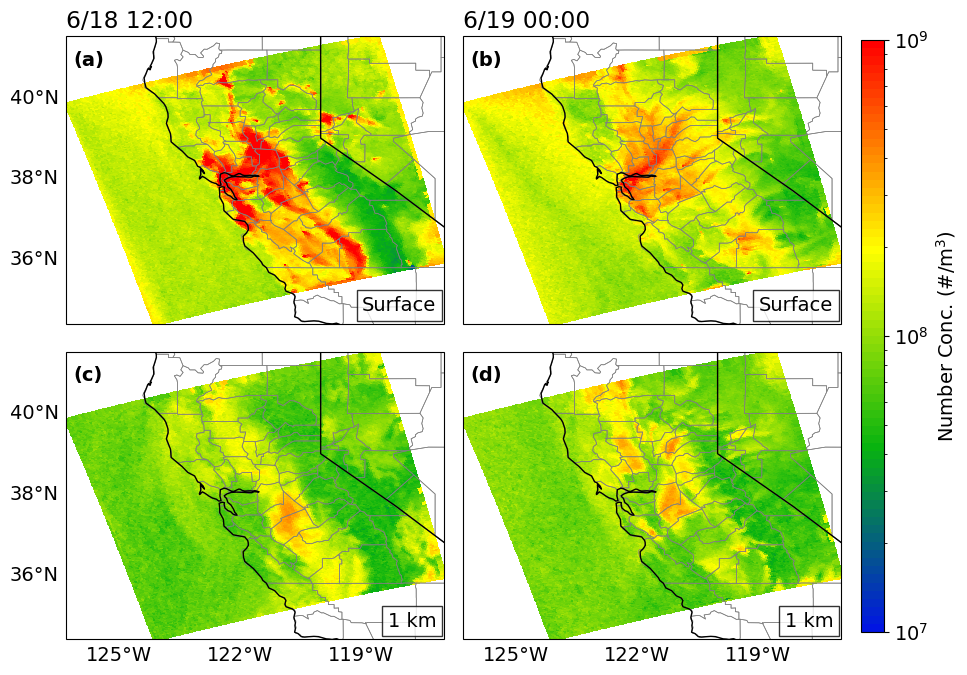

In [20]:
var_list = [tot_num_conc_map_00, tot_num_conc_map_12,
            tot_num_conc_map_00_1km, tot_num_conc_map_12_1km]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8),
                        subplot_kw=dict(projection=ccrs.PlateCarree()), 
                        gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
fig.subplots_adjust(right=0.9)  # Adjust the right margin for the colorbar

# Add text labels to each subplot
labels = [f'({chr(97+i)})' for i in range(4)]  # Generate labels (a), (b), ...
for ax, label in zip(axs.flat, labels):
    ax.annotate(label, xy=(0.02, 0.95), xycoords='axes fraction', fontsize=14, fontweight='bold',
                horizontalalignment='left', verticalalignment='top')

for i, ax in enumerate(axs.flat):
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])
    ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='grey', linewidth=0.5)

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    ax.add_feature(states_provinces, edgecolor='black')
    ax.coastlines(resolution='50m', color='black', linewidth=1)

    
    var = var_list[i]

    im = ax.pcolormesh(lons, lats, var[:, :], norm=colors.LogNorm(vmin=1e7, vmax=1e9), cmap=cmap,
                               transform=ccrs.PlateCarree(), shading='auto', edgecolor='face', antialiased=False)

    if i == 1:
        position = fig.add_axes([0.92, 0.127, 0.023, 0.74])  # [left, bottom, width, height]
        cbar = plt.colorbar(im, ax=axs, cax=position)
        cbar.set_label(r"Number Conc. ($\#$/$\rm m^{3}$)")

    if i == 0:
        ax.set_title('6/18 12:00', loc='left')
    if i == 1:
        ax.set_title('6/19 00:00', loc='left')
    if i < 2:
        ax.text(0.98, 0.03, 'Surface', transform=ax.transAxes, ha='right', va='bottom', bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))
    else:
        ax.text(0.98, 0.03, '1 km', transform=ax.transAxes, ha='right', va='bottom', bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))

    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='none')  # No grid lines
    
    # Customize longitude labels
    gl.xlocator = mticker.FixedLocator(range(-125, -116, 3))
    
    # Customize latitude labels
    gl.ylocator = mticker.FixedLocator(range(int(lats.min()), int(lats.max()), 2))  
    
    # Only show latitude labels on the left two subplots
    if i % 2 == 0:  # Left subplots
        gl.left_labels = True
    else:
        gl.left_labels = False
    
    # Only show longitude labels on the bottom two subplots
    if i >= 2:  # Bottom subplots
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    
    gl.top_labels = False
    gl.right_labels = False


plt.savefig('/data/keeling/a/xx24/d/proj_film/tot_num_conc_surface_and_1km.pdf', bbox_inches='tight')
plt.show()

In [9]:
# Calculate average of each DataFrame across all elements
avg_num_conc_00 = num_conc_00.mean().mean()
avg_num_conc_12 = num_conc_12.mean().mean()
avg_num_conc_00_1km = num_conc_00_1km.mean().mean()
avg_num_conc_12_1km = num_conc_12_1km.mean().mean()

print("Average num_conc_00: ", avg_num_conc_00)
print("Average num_conc_12: ", avg_num_conc_12)
print("Average num_conc_00_1km: ", avg_num_conc_00_1km)
print("Average num_conc_12_1km: ", avg_num_conc_12_1km)

pct_diff_00 = ((avg_num_conc_00 - avg_num_conc_00_1km) / avg_num_conc_00_1km) * 100
pct_diff_12 = ((avg_num_conc_12 - avg_num_conc_12_1km) / avg_num_conc_12_1km) * 100

print(f"At time '00': Surface num_conc is {pct_diff_00:.2f}% higher than 1km level.")
print(f"At time '12': Surface num_conc is {pct_diff_12:.2f}% higher than 1km level.")

Average num_conc_00:  207637978.09752047
Average num_conc_12:  161072339.9376153
Average num_conc_00_1km:  95398526.6507541
Average num_conc_12_1km:  99745842.51643628
At time '00': Surface num_conc is 117.65% higher than 1km level.
At time '12': Surface num_conc is 61.48% higher than 1km level.


In [11]:
# Calculate percentage difference relative to the surface value
pct_diff_00_times = ((avg_num_conc_00 - avg_num_conc_00_1km) / avg_num_conc_00) * 100
pct_diff_12_times = ((avg_num_conc_12 - avg_num_conc_12_1km) / avg_num_conc_12) * 100

print("Percent lower at 1km compared to surface at time '00':")
print(pct_diff_00_times)

print("\nPercent lower at 1km compared to surface at time '12':")
print(pct_diff_12_times)

Percent lower at 1km compared to surface at time '00':
54.055357538711604

Percent lower at 1km compared to surface at time '12':
38.07388496679896
